
# Explore DCE-MRI of the kidney   (work in progress ...)

BMED360-2021  `01-dce-mri-kidney-explore.ipynb`

<a href="https://colab.research.google.com/github/computational-medicine/BMED360-2021/blob/main/Lab5-DCE-MRI/01-dce-mri-kidney-explore.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
colab = False

## Learning objectives

- Define perfusion as a physiological process [[Lec4](https://docs.google.com/presentation/d/1C0WGl1qKrQdwrMKOMfWyTnnASLzECRKhvLhZozphJwQ)]
- Describe the principles of perfusion MRI (DSC-MR with first pass bolustracking)
- Provide an example with real data
- Explore the potential of K-means clustering of spatial signal intensity time courses ($\mathbf{R}^{50}$ as feature space)
- K-means "smoothing" of time courses (e.g. 64 "prototypic" time coureses in 3D+time DCE-MRI)

## Setup

In [2]:
# Set this to True if you are using Colab:
# colab = True

### For Google Colab

In [3]:
if colab == True:
    !pip install gdown
    !pip install nilearn
    !pip install sklearn

### Setup libraries and folders 

In [4]:
%matplotlib inline
import os
from os.path import expanduser, join, basename, split
import pathlib
import glob
import shutil
import platform
import gdown
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import imageio
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skimage

In [5]:
cwd = os.getcwd()
data_dir = join(cwd, 'data')
assets_dir = join(cwd, 'assets')
fn = f'{data_dir}/kidney_capio_20050419_series_13_32.nii.gz'

**Check your platform**

In [6]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:14 PST 2021; root:xnu-7195.101.1~3/RELEASE_X86_64)


### Download data from Google Drive using gdown** (https://github.com/wkentaro/gdown)

In [7]:
# Download zip-file if ./assets does not exist (as when running in Colab)

if os.path.isdir(assets_dir) == False:
    
    ## Download assets.zip for Google Drive             
    # https://drive.google.com/file/d/1fM6fIG9fuxX28_pQtrZZLyRxZZTF01tG/view?usp=sharing
    file_id = '1fM6fIG9fuxX28_pQtrZZLyRxZZTF01tG'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = './assets.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./assets`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `assets.zip` file
    os.remove(output)
else:
    print(f'./assets  exists already!')

./assets  exists already!


In [8]:
# Download zip-file if ./data does not exist (as when running in Colab)

if os.path.isdir(data_dir) == False:
    
    ## Download data.zip for Google Drive                
    # https://drive.google.com/file/d/13e8EqQF9xgdRdCCi-bB_BaYrkUCVs0sX/view?usp=sharing
    file_id = '13e8EqQF9xgdRdCCi-bB_BaYrkUCVs0sX'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = './data.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `data.zip` file
    os.remove(output)
else:
    print(f'./data  exists already!')

./data  exists already!


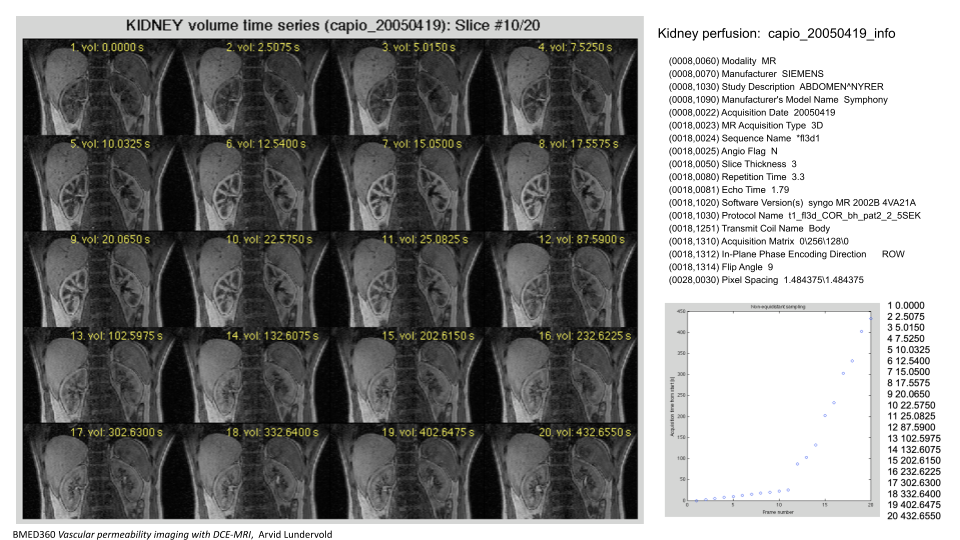

In [9]:
from IPython.display import Image
Image('./assets/BMED_360_Lec6_vascular_permeability_dce_mri_kidney_volme_time_series_capio_2005.png', width=900)

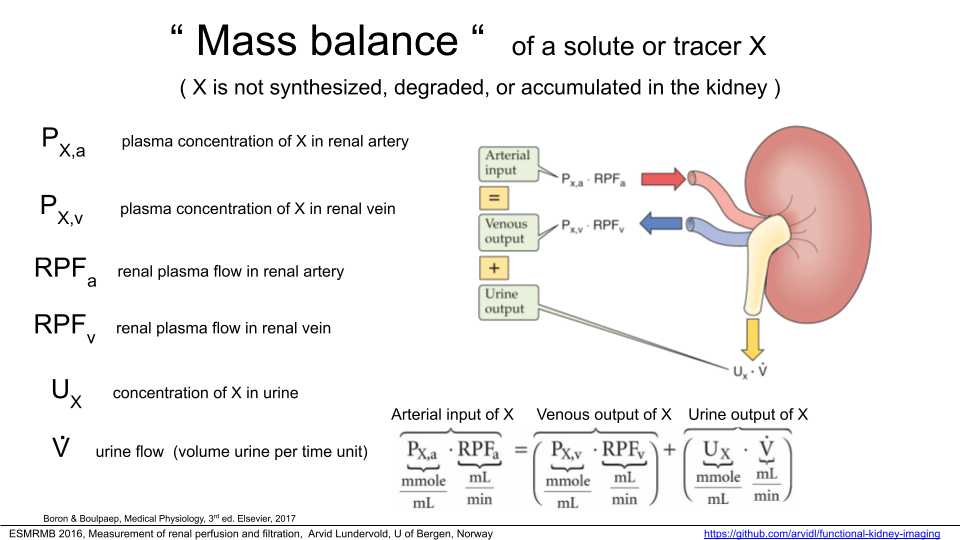

In [10]:
from IPython.display import Image
Image('./assets/BMED_360_Lec6_vascular_permeability_dce_mri_mass_balance_kidney_filtration.png', width=800)

## Read the 4D DSC-MRI data

In [11]:
# Using nibabel to read the brain DSC-MRI data
img = nib.load(fn)

In [12]:
aff = img.affine

**Print properties of the DSC-MRI NIFTI image**

In [13]:
print('**DSC-MRI data info:**')
print(img.get_filename())
print('shape of image = ', img.header.get_data_shape())
print('units = ', img.header.get_xyzt_units())
print('voxel size = ', img.header.get_zooms())
print('dtype = %s' % img.header.get_data_dtype())
data = img.get_fdata()
print('min = %.1f' % data.min())
print('max = %.1f' % data.max())
print('number of timepoints =', img.shape[-1])
# Collaps the singular (z-)dimension
img_data = np.uint16(data.squeeze())
print('shape of 4D img_data = ',img_data.shape)
print('dtype of 4D img_data = ',img_data.dtype)
print('img affine:', img.affine)
print(img.header)

**DSC-MRI data info:**
/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab5-DCE-MRI/data/kidney_capio_20050419_series_13_32.nii.gz
shape of image =  (256, 256, 20, 20)
units =  ('mm', 'sec')
voxel size =  (1.484375, 1.484375, 3.0, 2.50753)
dtype = int16
min = 0.0
max = 143.0
number of timepoints = 20
shape of 4D img_data =  (256, 256, 20, 20)
dtype of 4D img_data =  uint16
img affine: [[-1.48325932e+00 -8.00226443e-03  1.15163416e-01  1.78615036e+02]
 [-5.75410575e-02  2.06277654e-01 -2.96861410e+00  7.19649649e+00]
 [-6.66976918e-10 -1.46995068e+00 -4.17211592e-01  1.58915298e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 256 256  20  20   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code

**Display selected slice and four different timeframes**

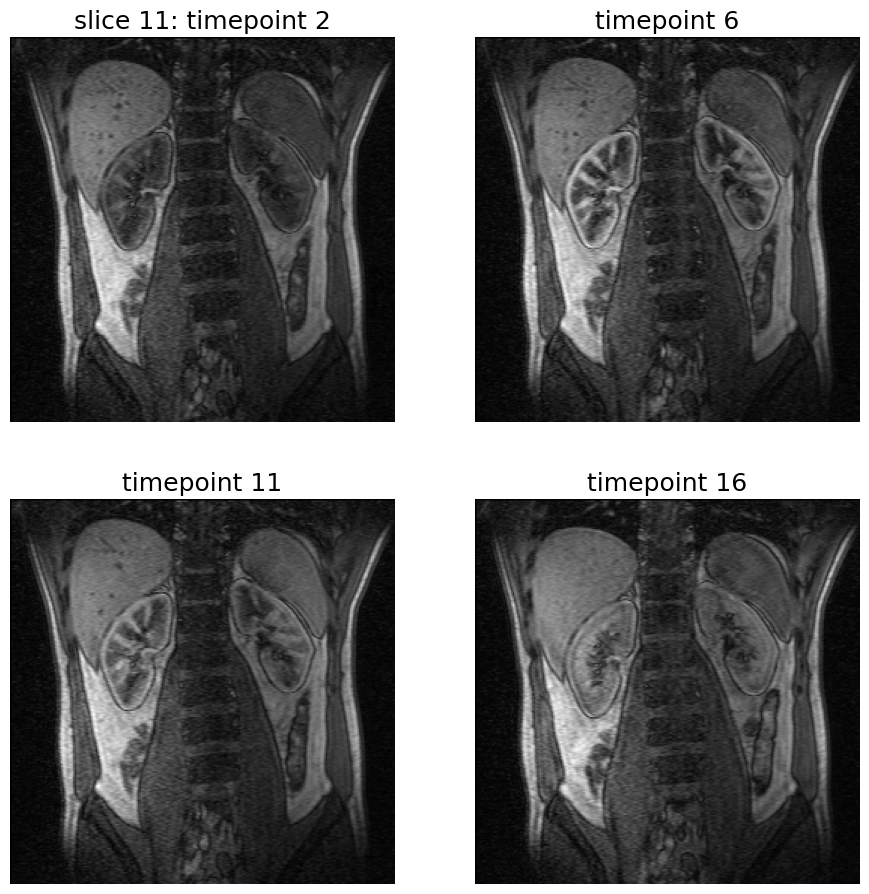

In [19]:
# Arrays starts at 0 (therefors add 1 in the figure)
s = 10
t = [1, 5, 10, 15]

fig = plt.figure('Showing the DSC-MRI image', figsize = [11,11])
plt.tight_layout
plt.subplot(2, 2, 1).set_axis_off(), plt.title('slice %d: timepoint %d' % (s+1, t[0]+1), fontsize=18)
#plt.imshow(np.fliplr(np.rot90(data[:, :, s, t[0]].squeeze(), k=3)), cmap='gray', origin='lower')  
plt.imshow(np.rot90(data[:, :, s, t[0]]), cmap='gray', origin='lower')  
plt.subplot(2, 2, 2).set_axis_off(), plt.title('timepoint %d' % (t[1]+1), fontsize=18)
plt.imshow(np.rot90(data[:, :, s, t[1]]), cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off(), plt.title('timepoint %d' % (t[2]+1), fontsize=18)
plt.imshow(np.rot90(data[:, :, s, t[2]]), cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off(), plt.title('timepoint %d' % (t[3]+1), fontsize=18)
plt.imshow(np.rot90(data[:, :, s, t[3]]), cmap='gray', origin='lower')
plt.show()

#fig.savefig('%s/prj/BMED360-2021/results/kidney_dce_mri_slice%d.png' % (home, s),
#            transparent=False, dpi=300, bbox_inches="tight")

In [20]:
# Number of voxels in the 4D image
print(data.flatten().min())
print(data.flatten().max())
data.flatten().size

0.0
143.0


26214400

In [21]:
# Generally, we could use an ROI mask for the kidney. We let this ROI be the whole first volume + 1, i.e.
data_msk = data[:,:,:,0]+1
print(data_msk.flatten().min())
print(data_msk.flatten().max())
data_msk.shape

1.0
133.0


(256, 256, 20)

**Find all pixel locations in the ROI for extracting a dataset X and corresponding pixel locations to a Pandas data frame (dfR)**

In [22]:
# Find voxel locations (ind_roi) corresponding to kidney ROI (value >=1 inside ROI, 0 else) 
ind_roi = np.where(data_msk > 0) 
X = np.asarray(img_data[ind_roi[0][:],ind_roi[1][:],ind_roi[2][:],:]) # The DCE-MRI voxel time courses within ROI
print(X.shape)

(1310720, 20)


In [18]:
#!freeview -v ./data/kidney_capio_20050419_series_13_32.nii.gz